In [1]:
import sys
import os
import yaml
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
import tensorflow as tf
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/storage/home/dxf424/work/script/course_repository/')
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency
import keras 

2022-08-09 23:44:31.534522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
!python -m pip install keras==2.4.0 --user

In [ ]:
import scipy.io as scio
temp=scio.loadmat('temp.mat')
best_hits_matrix_norm=temp['best_hits_matrix_norm']
pmm_best_hits_matrix_denorm=temp['pmm_best_hits_matrix_denorm']
input_times_grad(best_hits_matrix_norm[:,:,:,:], pmm_best_hits_matrix_denorm)

In [9]:
import scipy.io as scio
test = scio.loadmat('test_lead10_allIR')#test_lead10_allIR.mat')
test_data_scaled = test['test_data_scaled']
test_label = test['test_label'][:][0,:]

In [10]:
#test_label = test['test_label']
print(test_label.shape)

(3781,)


In [31]:
my_model = utils.read_dense_net("/glade/work/fanda/model_ensemble/old/goes16_resnet_gpus_01.h5")#,custom_objects={'loss_func_CE': loss_func_CE})
my_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 68)   4352        scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 68)   272         conv2d_21[0][0]                  
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 32, 32, 68)   0           bn_res_00_a[0][0]                
____________________________________________________________________________________________

In [46]:
import shap
def m(X):
  return my_model.predict(X)

def explain_multiband(data, masker):
  # Initialize PartitionShap explainer
  explainer = shap.Explainer(m, masker)

  # Explain batch (calculate SHAP values)
  shap_values = explainer(data, max_evals=10000)

  return shap_values

In [32]:
# set the probability threshold for binary classification; predict on validation; add binary preds
#import keras
#my_model = keras.models.load_model("goes16ci_model_cpu_lead10_allIR.h5")#models/goes16ci_model_cpu2022-06-06 15:28:51.532054.h5")#"goes16ci_model_cpu_lead0_allIR.h5")
#my_model = tf.saved_model.load("/storage/home/dxf424/work/scrip/goes16ci_model_cpu_lead10_allIR.h5")
binary_threshold = 0.5
preds = my_model.predict(test_data_scaled).reshape(test_label.shape)
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [33]:
np.sum(binary_preds)

2655

In [34]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score, accuracy_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(F)
    POD = H/(H+M)
    POFD = F/(F+C)
    FAR = F/(F+H)
    SR = H/(F+H)
    CSI = H/(H+F+M)
    return POD, POFD, FAR, SR, CSI
#tn, fp, fn, tp
def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [35]:
print("Total score for {} is {}".format(1,2))
scores(test_label, binary_preds)

Total score for 1 is 2
770


(0.8959125475285171,
 0.45915324985092426,
 0.2900188323917137,
 0.7099811676082862,
 0.6558803061934586)

In [36]:
# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, binary_preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),3)))

RMSE: 0.41999998688697815
R squared: 0.296
Hellenger Distance: 0.588
770
POD: 0.8959125475285171, POFD: 0.45915324985092426, FAR: 0.2900188323917137, SR: 0.7099811676082862, CSI:0.6558803061934586
Heidke Skill Score: 0.452
[[ 907  770]
 [ 219 1885]]
Pierce Skill Score: 0.437
Brier Score: 0.262
Brier Skill Score: -0.06
Accuracy score: 0.738
AUC: 0.8


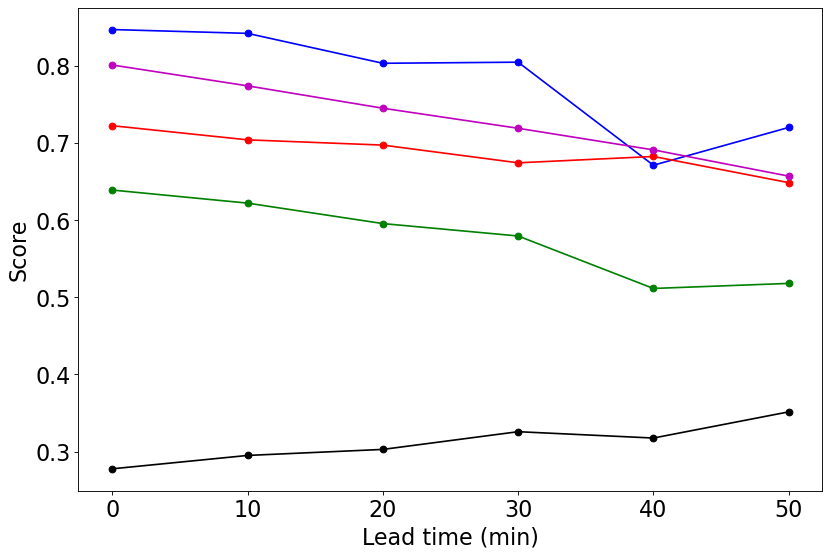

In [64]:
index=np.arange(0,60,10)
POD=[0.846958174904943, 0.842, 0.8032319391634981, 0.8046577946768061, 0.6711026615969582, 0.7200570342205324]
SR=[0.7223348196189704, 0.704, 0.6971947194719472, 0.6742333731581044, 0.6824552924117931, 0.6485445205479452]
CSI=[0.6389386877016852, 0.622, 0.5954897815362932, 0.579397672826831, 0.5114089098152843, 0.517948717948718]
AUC=[0.801, 0.774, 0.745, 0.719, 0.691, 0.657]
FAR=[0.2776651803810296, 0.295, 0.3028052805280528, 0.32576662684189567, 0.31754470758820685, 0.3514554794520548]
# plot lines
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(index, POD, 'bo-',label = "POD")
plt.plot(index, SR, 'ro-', label = "SR")
plt.plot(index, CSI, 'go-', label = "CSI")
plt.plot(index, AUC, 'mo-',label = "AUC")
plt.plot(index, FAR, 'ko-',label = "FAR")
#plt.legend()
#plt.rcParams["legend.loc"] = 'left'
plt.ylabel('Score')
plt.xlabel('Lead time (min)')
plt.xticks((0,10,20,30,40,50))
plt.show()

In [39]:
#print(preds[test_label==1])
#np.where((dists >= r) & (dists <= r + dr))
indices = (np.where((test_label==1) & (binary_preds==1)))[0]
ind = np.argpartition(preds[indices], -10)[-10:]
#ind = np.argpartition(preds[indices], -100)[-100:]
best_hit_indices = indices[ind]

indices = (np.where((test_label==0) & (binary_preds==1)))[0]
ind = np.argpartition(preds[indices], -100)[-100:]
worst_false_alarm_indices = indices[ind]

indices = (np.where((test_label==1) & (binary_preds==0)))[0]
ind = np.argpartition(-preds[indices], -100)[-100:]
worst_miss_indices = indices[ind]

indices = (np.where((test_label==0) & (binary_preds==0)))[0]
ind = np.argpartition(-preds[indices], -100)[-100:]
best_correct_null_indices = indices[ind]

print(indices.shape)
print(indices[ind])

(907,)
[   7 1740  768 2988 3147 2702 2174 2035 2938 2893 2403 3006 3425 1963
 2883 2399 1258  191  604 2853 2010 2455 2903 2322 2805 2984 3632 3079
   37  659  647 1391  622 1626 1334 3276 3275 3596  478 3595 2432 2527
 1523 3583  569  514 2524 1097 1379 2280 1930 1686 1889 3234 2434  642
  719 3282 2170 1423 3507 3640 3038 2065 1273 2582 3702 1245   33 3041
 2573 3661  234 1001   21 1026  213 2003 3357 1831 1113 3694 1763 2804
  291 2358 1445 2764 1406 3610 3599 1365  616  715  733 2407 2052 1161
 1136 2332]


In [40]:
# Best hits
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_hit_indices])
# Worst false alarms
pmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_false_alarm_indices])
# Worst misses
pmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[worst_miss_indices])
# Best correst nulls
pmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(test_data_scaled[best_correct_null_indices])


In [ ]:
pmm_best_hits_matrix_denorm.shape

In [ ]:
preds[indices[ind]]

In [43]:
best_hits_matrix_norm=test_data_scaled[best_hit_indices]

In [ ]:
print(my_model.layers[-1].name)

In [41]:
def input_times_grad(matrix_norm, pmm_matrix_denorm ):
  print('ok')
  saliency_matrix = utils.get_saliency_one_neuron(
      model_object=my_model,
      predictor_matrix=matrix_norm,
      layer_name=my_model.layers[-1].name,
      neuron_indices=np.array([0], dtype=int),
      ideal_activation=1.
  )
  input_times_grad_matrix = (saliency_matrix * matrix_norm)

  input_times_grad_matrix = utils.run_pmm_many_variables(
      field_matrix=input_times_grad_matrix
  )
  input_times_grad_matrix = saliency.smooth_saliency_maps(
      saliency_matrices=[input_times_grad_matrix],
      smoothing_radius_grid_cells=1
  )[0]

  plot_storm_xai(pmm_matrix_denorm, input_times_grad_matrix)

def plot_storm_xai(values, shap_values):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 7, figsize=(24, 18))

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)

  # Reflectivity
  ax[0][0].set_title("CH8 BT")
  ax[0][0].pcolormesh(values[:,:,0], 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None') 
  ax[0][0].axis('off')
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,0])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  ax[0][1].set_title("CH9 BT")
  ax[0][1].pcolormesh(values[:,:,1], 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None') 
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,1])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  #image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  ax[0][2].set_title("CH10 BT")
  ax[0][2].pcolormesh(values[:,:,2], 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,2])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  ax[0][3].set_title("CH11 BT")
  ax[0][3].pcolormesh(values[:,:,3], 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,3])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  ax[0][4].set_title("CH12 BT")
  ax[0][4].pcolormesh(values[:,:,4], 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][4].axis('off')
  ax[1][4].imshow(values[:,:,4], cmap="gray", alpha=0.15)
  ax[1][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][4].invert_yaxis()
  ax[1][4].axis('off')
  ax[2][4].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,4])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][4].imshow(shap_values[:,:,4], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][4].invert_yaxis()
  ax[2][4].axis('off')

  ax[0][5].set_title("CH13 BT")
  ax[0][5].pcolormesh(values[:,:,5], 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][5].axis('off')
  ax[1][5].imshow(values[:,:,5], cmap="gray", alpha=0.15)
  ax[1][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][5].invert_yaxis()
  ax[1][5].axis('off')
  ax[2][5].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,5])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][5].imshow(shap_values[:,:,5], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][5].invert_yaxis()
  ax[2][5].axis('off')

  ax[0][6].set_title("CH14 BT")
  ax[0][6].pcolormesh(values[:,:,6], 
                      cmap='seismic',
                      norm=None,
                      vmin=0,
                      vmax=1,
                      shading="flat", edgecolors='None')  
  ax[0][6].axis('off')
  ax[1][6].imshow(values[:,:,6], cmap="gray", alpha=0.15)
  ax[1][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][6].invert_yaxis()
  ax[1][6].axis('off')
  ax[2][6].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,6])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][6].imshow(shap_values[:,:,6], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][6].invert_yaxis()
  ax[2][6].axis('off')

  plt.tight_layout()

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)

In [15]:
!python3.8 -m pip install shap --user

In [54]:
best_hits_matrix_norm.shape

(10, 32, 32, 7)

In [57]:
X[0].shape

(32, 32, 7)

In [47]:
import shap
X = best_hits_matrix_norm
print(X[0].shape)
#Xplot = best_hits_matrix_denorm
# Evaluate 
masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape)#, partition_scheme=1)
shap_values = explain_multiband(X, masker_uniform_0)
# Plot first 5 samples
#plot_storm_xai_batch(Xplot[0:5], shap_values[0:5].values)

(32, 32, 7)


  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 3/10 [00:32<00:51,  7.38s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 4/10 [00:47<01:03, 10.59s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 5/10 [01:01<01:00, 12.08s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 6/10 [01:17<00:52, 13.16s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 7/10 [01:31<00:40, 13.64s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 8/10 [01:46<00:28, 14.10s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 9/10 [02:01<00:14, 14.25s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 10/10 [02:16<00:00, 14.55s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 11it [02:31, 15.13s/it]                        


In [52]:
shap_values_pmm[:,:,0,0]

array([[-1.74317792e-05, -1.71237859e-05, -1.66252299e-05, ...,
        -6.11280902e-05, -5.81706502e-05, -5.80204384e-05],
       [-1.57873325e-05, -1.54232441e-05, -1.58034310e-05, ...,
        -6.17595130e-05, -5.79936800e-05, -5.83781092e-05],
       [-6.50913927e-05, -6.53872043e-05, -8.15445934e-05, ...,
        -1.17901344e-04, -1.12510313e-04, -1.13373519e-04],
       ...,
       [-1.55214393e-04, -1.55947611e-04, -1.76318604e-04, ...,
        -2.05996258e-05, -2.00228454e-05, -1.96305518e-05],
       [-7.31457206e-05, -7.28570417e-05, -8.50724555e-05, ...,
        -4.95894548e-07, -3.26046422e-06, -3.92024845e-06],
       [-7.38500821e-05, -7.38500821e-05, -8.50724555e-05, ...,
        -1.44538369e-06, -3.52557790e-06, -3.26046422e-06]])

In [53]:
shap_values_pmm[:,:,1,0]

array([[-1.58297757e-05, -1.71237859e-05, -1.62130966e-05, ...,
        -6.11280902e-05, -5.80204384e-05, -5.81706502e-05],
       [-1.57873325e-05, -1.52750409e-05, -1.58034310e-05, ...,
        -6.04486183e-05, -5.79798747e-05, -5.82807921e-05],
       [-6.47065777e-05, -6.59843835e-05, -8.12645045e-05, ...,
        -1.17582896e-04, -1.12637707e-04, -1.13295576e-04],
       ...,
       [-1.55214393e-04, -1.55947611e-04, -1.73869933e-04, ...,
        -2.00838834e-05, -2.00228454e-05, -1.97235090e-05],
       [-7.31457206e-05, -7.29957219e-05, -8.66879560e-05, ...,
        -4.95894548e-07, -3.92024845e-06, -3.92024845e-06],
       [-7.38500821e-05, -7.40216109e-05, -8.50376224e-05, ...,
        -1.60508681e-06, -3.52557790e-06, -3.26046422e-06]])

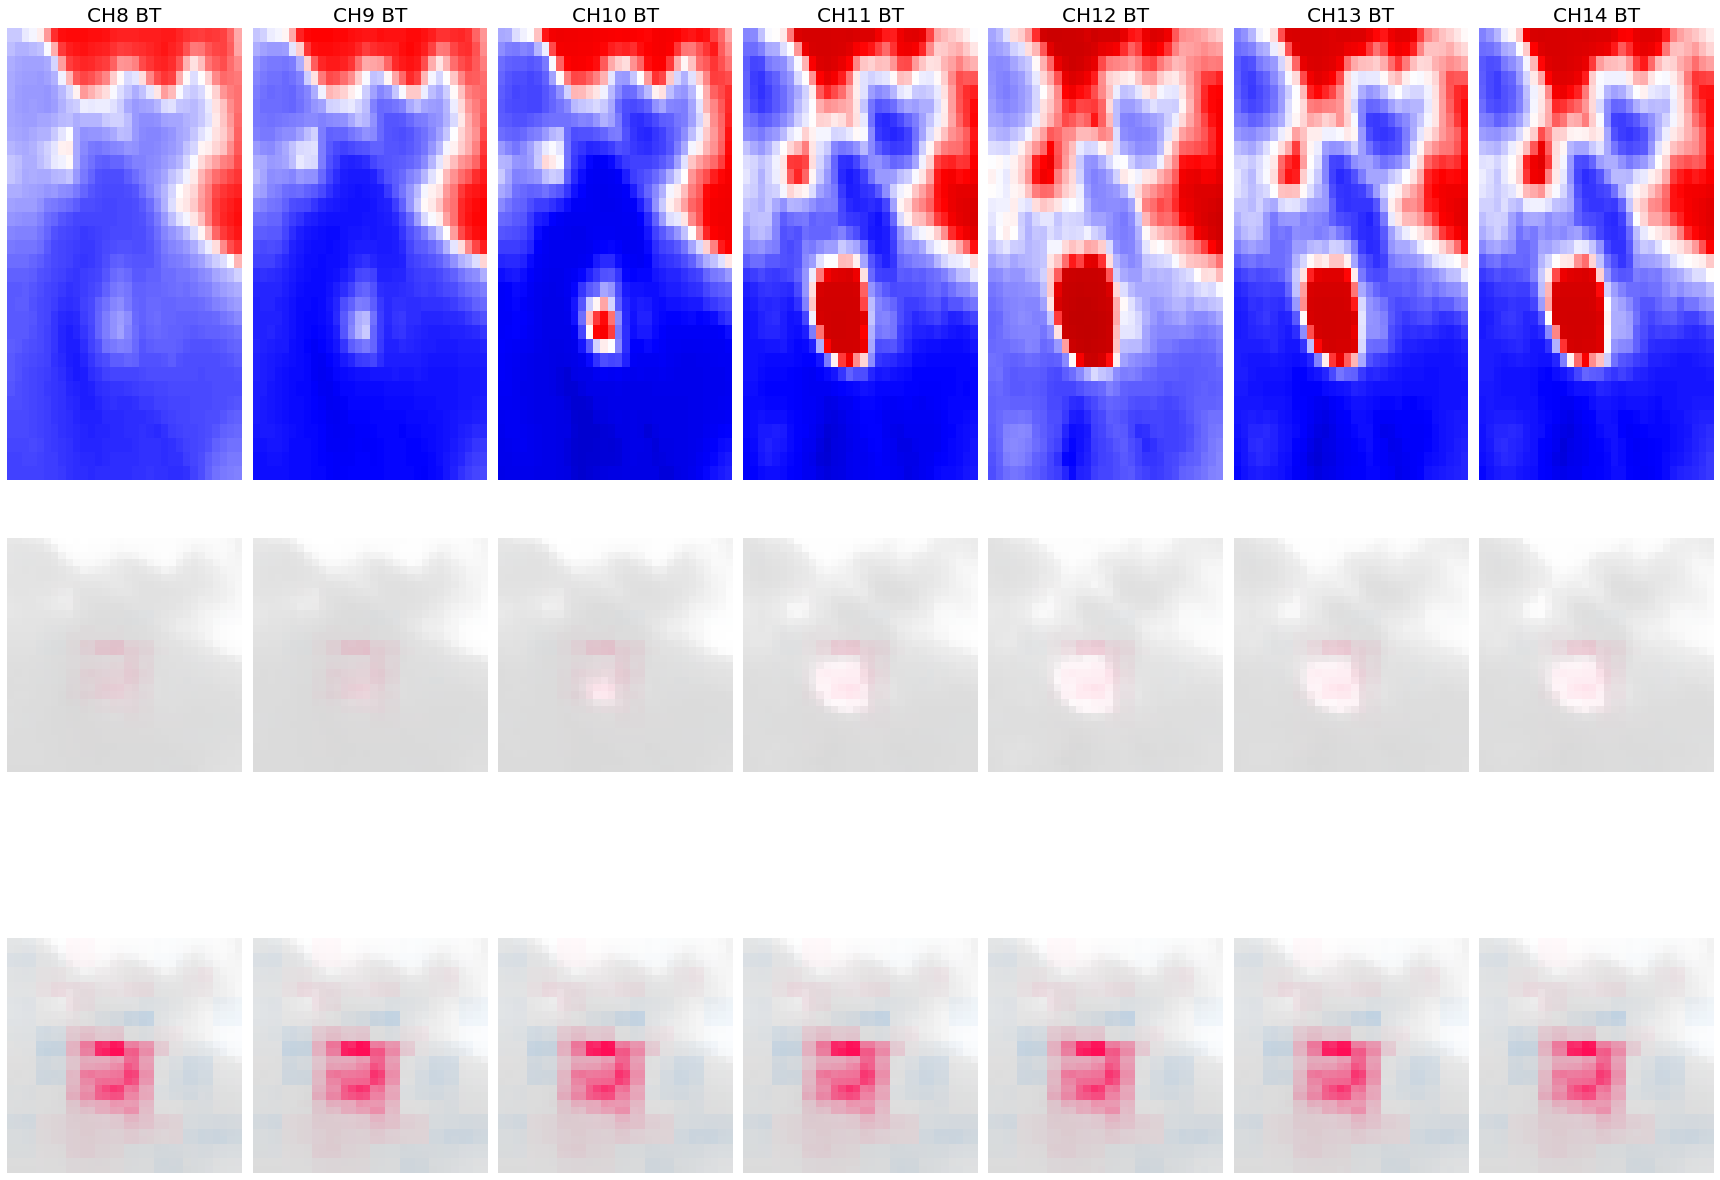

In [60]:
import copy
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
#plot_storm_xai_batch(pmm_best_hits_matrix_denorm, 
#                      shap_values_pmm)
plot_storm_xai_batch(np.expand_dims(pmm_best_hits_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

In [ ]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

In [ ]:
#tf.compat.v1.enable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(True)
#tf.config.run_functions_eagerly(True)
a=my_model.get_layer(name=my_model.layers[-1].name).output[..., 0] #.output[..., 1]

In [ ]:
best_hits_matrix_norm.shape

In [ ]:
import tensorflow as tf
tf.GradientTape

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [ ]:
!pip install h5py==2.10.0 --user yy

In [ ]:
print(1.dtype)

In [ ]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
import scipy.io as scio
scio.savemat('temp.mat',{'best_hits_matrix_norm':best_hits_matrix_norm, 'pmm_best_hits_matrix_denorm':pmm_best_hits_matrix_denorm})

In [ ]:
import scipy.io as scio
test=scio.loadmat('test.mat')
loss_tensor=test['loss_tensor']
input_tensors=test['input_tensors']


In [ ]:
print(input_tensors)

In [61]:
#config = tf.compat.v1.ConfigProto
#import keras
#session = keras.backend.get_session()
#init = tf.global_variables_initializer()
#session.run(init)
#my_model = utils.read_dense_net("goes16ci_model_cpu_lead10_allIR.h5")
#my_model.summary()
#import tensorflow._api.v2.compat.v1 as tf
#tf.compat.v1.disable_eager_execution()
#tf.disable_v2_behavior()
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)
import scipy.io as scio
temp=scio.loadmat('temp.mat')
best_hits_matrix_norm=temp['best_hits_matrix_norm']
pmm_best_hits_matrix_denorm=temp['pmm_best_hits_matrix_denorm']
input_times_grad(best_hits_matrix_norm[:,:,:,:], pmm_best_hits_matrix_denorm)

FileNotFoundError: [Errno 2] No such file or directory: 'temp.mat'

In [ ]:
print(my_model.input)

In [ ]:
tensor_train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(tensor_train_images)
    model.evaluate(x=tensor_train_images,y=train_labels, steps=10)
print(tape.gradient(model.total_loss,tensor_train_images))

In [ ]:
import tensorflow.python.keras.backend as K
loss=tf.convert_to_tensor([1], dtype=tf.float32)
var=tf.convert_to_tensor([2], dtype=tf.float32)
with tf.GradientTape() as tape:
    a=1
a=tape.gradient(loss, var)

In [ ]:
print(loss)

In [ ]:
best_hits_matrix_norm[0].shape

In [ ]:
with tf.GradientTape() as tape:
         print('ok')

In [ ]:
pmm_best_hits_matrix_denorm.shape

In [ ]:
!pip install tensorflow==2.4.0 --user

In [ ]:
ch = np.arange(8,15)
print(ch)
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

In [ ]:
print(np.shape(test_data_scaled))

In [ ]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(my_model, [test_data_scaled, test_data_scaled])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([test_data_scaled[3,:,:,:]])
# plot the feature attributions
#shap.image_plot(shap_values, -test_data_scaled[100:105,:,:,:])

In [ ]:
!pip install tf-explain --user

In [ ]:
import shap
shap_values = shap.DeepExplainer(my_model).shap_values(test_data_scaled)
shap.summary_plot(shap_values, test_data_scaled, plot_type="bar")

In [ ]:
!pip install tensorflow==2.6.0 --user

In [ ]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(test_data_scaled, test_label),
        layers_name=["activation_1"],
        output_dir='.',
    ),
]

my_model.fit(test_data_scaled, test_label, batch_size=1024, epochs=2, callbacks=callbacks)


In [ ]:
def plot_storm_array(predictor_matrix, labels, contour=False):
    """Plots each channel of a storm-centered raster loaded from NetCDF file.
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)
    
    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param labels: C-length list of feature names to label each output. 
  """

    fig, ax = plt.subplots(1, len(labels), figsize=(15, 3))
    for i in range(len(labels)):

        # Contour plot
        if contour:
          a=ax[i].contourf(predictor_matrix[:,:,i])
          if i == 0:
            b=a
        # Image plot
        else:
          ax[i].imshow(predictor_matrix[:,:,i])
          ax[i].invert_yaxis()

        ax[i].set_title(labels[i])
        ax[i].axis('off')
    fig.colorbar(a, orientation='vertical')
print("Sample storm image:")
feature_names=['CH8','CH9','CH10','CH11','CH12','CH13','CH14',]
print(test_label[10])
plot_storm_array(test_data_scaled[10,:,:,:], labels=feature_names, contour=True)

In [ ]:
if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')
!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository

In [ ]:
!pip install dill --user

In [ ]:
sys.path.append('/storage/home/dxf424/work/script/course_repository/')
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency

In [ ]:
import pythran
!cd course_repository; python setup.py install --user

In [ ]:
!pip install pythran --user

In [ ]:
print(image_utils.PREDICTOR_MATRIX_KEY)

In [ ]:
data = test_data_scaled
predictor_matrix_denorm = data[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = data[image_utils.PREDICTOR_NAMES_KEY]
predictor_matrix_norm = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

# Predict the first 5
preds = my_model.predict(predictor_matrix_norm[0][0:5,:])
print(preds)

In [ ]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
grid = explainer.explain((test_data_scaled[1:3,:,:,:],None), my_model, class_index=1)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
test_data_scaled[1:5].shape

In [ ]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = test_data_scaled[np.random.choice(test_data_scaled.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(my_model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(test_data_scaled[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -test_data_scaled[1:5])

In [ ]:
!pip install xgboost --user

In [ ]:
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=281)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
from tf_explain.callbacks.vanilla_gradients import VanillaGradientsCallback

model = [...]

callbacks = [
    VanillaGradientsCallback(
        validation_data=(test_data_scaled, test_label),
        class_index=0,
        output_dir='.',
    ),
]

my_model.fit(test_data_scaled, test_label, batch_size=1024, epochs=2, callbacks=callbacks)

In [ ]:
GOES-only(lead_time=10):POD: 0.8597816960537363, POFD: 0.587152516904583, FAR: 0.43284408751038495, SR: 0.567155912489615, CSI:0.5191381495564005

In [ ]:
index = (binary_preds==0) & (test_label==1)

In [ ]:
np.sum(index)